#INSTALLING & IMPORTING REQUIRED PACKAGES/LIBRARIES

In [ ]:
import pandas as pd      # Dataset Processing
import numpy as np       # Arrays Processing

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Calculation
import time

# Data Splitting
from sklearn.model_selection import train_test_split

# Exploratory Data Analysis (Personal Module)
import SimpleExploratoryDataAnalysis as eda

# Data Preprocessing:
# Feature Additon (Calculating Distance on Earth)
from geopy.distance import geodesic
# Feature Transformer
# from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler #PowerTransformer
# Dimensionality Reduction
# from sklearn.decomposition import PCA

# Model Building:
# Creating Transformer Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Feature Imputer
from sklearn.impute import SimpleImputer

# Pipeline Modeling
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Hyperparameter Tuning
import optuna

# Algorithms
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

# Evaluation Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


#I. BUSINESS UNDERSTANDING



The goal is to predict the fare amount of a taxi ride from a dataset containing some information such as:
* fare_amount = the amount of money passengers have to pay for a taxi ride
* pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, & dropoff_latitude = latitude and longitude coordinates where passengers start and end the rides
* passenger_count = the number of passengers

#II. DATA COLLECTION

##i. Dataset Extraction

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATA_SCIENCE/Datasets/Taxi_Fare.csv')

#III. DATA UNDERSTANDING
* Checking Missing Value Existance
* Statistical Description
* Detecting Anomalies
* Checking The Data Types of Each Column

In [ ]:
# Checking missing values
df.isnull().any()

fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count       True
dtype: bool

In [ ]:
# Statistical Description of The Dataset
print(df.shape)
df.describe(include='all', percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).T

(18919, 7)


,count,unique,top,freq,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
fare_amount,18919.0,NaN,NaN,NaN,11.288863,9.551542,-3.0,4.5,5.5,6.5,7.3,8.5,9.7,11.3,14.1,20.5,180.0
pickup_datetime,18919,18853,2014-11-25 22:20:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_longitude,18919.0,NaN,NaN,NaN,-72.486912,10.503536,-74.438233,-74.002781,-73.994753,-73.990209,-73.985782,-73.981753,-73.977176,-73.971072,-73.961919,-73.950851,40.766125
pickup_latitude,18919.0,NaN,NaN,NaN,39.925316,6.715053,-74.006893,40.718036,40.729885,40.739639,40.746699,40.752625,40.758874,40.764038,40.771166,40.77997,401.083332
dropoff_longitude,18919.0,NaN,NaN,NaN,-72.498812,10.461399,-84.654241,-74.002782,-73.993844,-73.988998,-73.984365,-73.980238,-73.975498,-73.968854,-73.958488,-73.944699,40.802437
dropoff_latitude,18919.0,NaN,NaN,NaN,39.913157,6.160511,-74.006377,40.713785,40.728671,40.739569,40.747626,40.753565,40.759206,40.764293,40.77246,40.782716,41.366138
passenger_count,18918.0,NaN,NaN,NaN,1.657205,1.282236,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,6.0


In [ ]:
# Checking the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18919 entries, 0 to 18918
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        18919 non-null  float64
 1   pickup_datetime    18919 non-null  object 
 2   pickup_longitude   18919 non-null  float64
 3   pickup_latitude    18919 non-null  float64
 4   dropoff_longitude  18919 non-null  float64
 5   dropoff_latitude   18919 non-null  float64
 6   passenger_count    18918 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.0+ MB


Notes:
1. Removing Missing Values
2. Checking for negative or zero values in column fare_amount
3. Checking for anomalies in the extracted columns -- Convert the data type into datetime! (in the data preprocessing section)
4. Checking for data points with zero values in columns pickup_latitude, pickup_longitude, dropoff_latitude, or dropoff longitude
5. Checking for anomalies in column pickup_longitude (Detect the upper anomalies!)
6. Checking for anomalies in column pickup_latitude (Detect the upper anomalies!)
7. Checking for anomalies in column dropoff_longitude (Detect the upper anomalies!)
8. Checking for anomalies in column dropoff_latitude (Detect the lower anomalies!)
9. Checking for data points with zero, negative, or non integer values in column passenger_count
10. Checking for data points that the pickup_latitude with dropoff latitude columns and the pickup_longitude with dropoff_longitude columns have the same values

#IV. DATA CLEANSING

In [ ]:
# 1. Removing missing values:
df.dropna(inplace=True)

In [ ]:
# 1. Checking for missing values:
data_shape     = df.shape
miss_val_exist = df.isnull().any().any()
print(f"The shape of the data now is {data_shape}")
print(f"The existence of missing values is {miss_val_exist}")

The shape of the data now is (18918, 7)
The existence of missing values is False


In [ ]:
# 2. Checking for negative or zero values in column fare_amount:
df[df['fare_amount'] <= 0]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.9,2010-03-09 23:37:10,-73.789450,40.643498,-73.788665,40.641952,1.0
2486,-2.5,2015-03-22 05:14:27,-74.000031,40.720631,-73.999809,40.720539,1.0
10002,0.0,2010-02-15 14:26:01,-73.987115,40.738808,-74.005911,40.713960,1.0
13032,-3.0,2013-08-30 08:57:10,-73.995062,40.740755,-73.995885,40.741357,4.0


In [ ]:
# 2. Removing the data points with negative or zero values from column fare_amount:
df = df[df['fare_amount'] > 0]

In [ ]:
# 3. Extracting column pickup_datetime to check for anomalies:
df['pickup_datetime_converted'] = pd.to_datetime(df['pickup_datetime'])
df['year']      = df['pickup_datetime_converted'].dt.year
df['month']     = df['pickup_datetime_converted'].dt.month
df['dayofweek'] = df['pickup_datetime_converted'].dt.dayofweek

In [ ]:
# 3. Checking for anomalies in the extracted columns:
# df['year'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])
# df['month'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])
df['dayofweek'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

count    18914.000000
mean         3.035371
std          1.965350
min          0.000000
10%          0.000000
20%          1.000000
30%          2.000000
40%          2.000000
50%          3.000000
60%          4.000000
70%          4.000000
80%          5.000000
90%          6.000000
max          6.000000
Name: dayofweek, dtype: float64

In [ ]:
# 3. No Anomalies Found in column pickup_datetime, Dropping the extracted columns:
df.drop(columns=['pickup_datetime_converted', 'year', 'month', 'dayofweek'], axis=1, inplace=True)

In [ ]:
# 4. Checking for data points with zero values in columns pickup_latitude, pickup_longitude, dropoff_latitude, or dropoff longitude
df[(df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0) | (df['dropoff_longitude'] == 0) | (df['dropoff_latitude'] == 0)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
11,5.5,2012-12-24 11:24:00,0.0,0.0,0.000000,0.000000,3.0
15,5.0,2013-11-23 12:57:00,0.0,0.0,0.000000,0.000000,1.0
26,6.5,2011-02-07 20:01:00,0.0,0.0,0.000000,0.000000,1.0
124,8.0,2013-01-17 17:22:00,0.0,0.0,0.000000,0.000000,2.0
192,3.7,2010-09-05 17:08:00,0.0,0.0,0.000000,0.000000,5.0
...,...,...,...,...,...,...,...
18570,8.5,2013-06-30 20:43:43,0.0,0.0,0.000000,0.000000,1.0
18771,3.5,2013-01-07 11:56:00,0.0,0.0,0.000000,0.000000,1.0
18796,11.7,2011-11-01 23:41:00,0.0,0.0,0.000000,0.000000,2.0
18842,2.5,2015-02-24 12:18:32,0.0,0.0,-73.993217,40.743061,2.0


In [ ]:
# 4. Removing the data points with zero values from columns pickup_latitude, pickup_longitude, dropoff_latitude, or dropoff longitude
df = df[(df['pickup_longitude'] != 0) & (df['pickup_latitude'] != 0) & (df['dropoff_longitude'] != 0) & (df['dropoff_latitude'] != 0)]

In [ ]:
# 5. Checking for anomalies in column pickup_longitude (Detect the upper anomalies!):
# df.sort_values(by='pickup_longitude')[df['pickup_longitude'] >= 0 ]
df.sort_values(by='pickup_longitude')[df['pickup_longitude'] <= 0 ]

<ipython-input-114-ab36939e6d2c>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.sort_values(by='pickup_longitude')[df['pickup_longitude'] <= 0 ]


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
649,66.3,2009-09-19 10:34:41,-74.438233,40.993260,-74.185996,40.693874,2.0
1335,180.0,2013-01-16 20:19:58,-74.429332,40.500046,-74.429332,40.500046,1.0
12940,3.7,2010-10-30 10:16:00,-74.229138,40.572183,-74.227047,40.581207,1.0
10524,75.8,2010-05-04 14:12:00,-74.181602,40.687722,-74.181602,40.687722,1.0
9090,5.7,2010-08-05 16:41:00,-74.133710,40.651728,-74.135442,40.650247,5.0
...,...,...,...,...,...,...,...
16890,17.7,2010-05-05 09:43:32,-73.137393,41.366138,-73.137393,41.366138,1.0
6416,6.1,2010-05-28 19:26:49,-73.137393,41.366138,-73.137393,41.366138,1.0
14367,14.1,2010-05-28 13:00:49,-73.137393,41.366138,-73.137393,41.366138,1.0
16689,7.3,2010-09-12 01:11:00,-72.856968,40.589230,-72.854940,40.589095,2.0


In [ ]:
# 5. Removing the anomalies from column pickup_longitude:
df.drop(index=1181, inplace=True)

<ipython-input-115-068e50a3e75a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=1181, inplace=True)


In [ ]:
# 6. Checking for anomalies in column pickup_latitude (Detect the upper anomalies!):
# df.sort_values(by='pickup_latitude')[df['pickup_latitude'] <= 0]
df.sort_values(by='pickup_latitude')[df['pickup_latitude'] >= 0]

<ipython-input-116-54714b184686>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.sort_values(by='pickup_latitude')[df['pickup_latitude'] >= 0]


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
11619,11.3,2011-05-27 21:47:44,-73.945106,39.603178,-73.976636,40.749643,1.0
10710,3.7,2011-02-11 21:46:09,-73.955411,39.604164,-73.955647,40.772837,1.0
8584,8.1,2011-05-24 13:46:23,-73.964460,39.616075,-73.946669,39.604972,1.0
8334,2.9,2011-02-21 12:16:33,-73.967160,39.617851,-73.976375,39.605025,1.0
8176,10.5,2011-04-08 12:58:26,-73.967350,39.627358,-73.959343,39.625547,1.0
...,...,...,...,...,...,...,...
6416,6.1,2010-05-28 19:26:49,-73.137393,41.366138,-73.137393,41.366138,1.0
4487,4.9,2009-08-26 07:43:16,-73.137393,41.366138,-73.957685,40.765644,1.0
5648,7.7,2010-04-28 19:06:13,-73.137393,41.366138,-73.137393,41.366138,1.0
16890,17.7,2010-05-05 09:43:32,-73.137393,41.366138,-73.137393,41.366138,1.0


In [ ]:
# 6. Removing the anomalies from column pickup_latitude:
df.drop(index=5686, inplace=True)

In [ ]:
# 7. Checking for anomalies in column dropoff_longitude (Detect the upper anomalies!):
df.sort_values(by='dropoff_longitude')[df['dropoff_longitude'] <= 0]
# df.sort_values(by='dropoff_longitude')[df['dropoff_longitude'] >= 0]

<ipython-input-118-5e2654955d9e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.sort_values(by='dropoff_longitude')[df['dropoff_longitude'] <= 0]


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
18680,6.5,2010-01-30 00:05:13,-73.994439,40.750632,-84.654241,-2.269701,1.0
1335,180.0,2013-01-16 20:19:58,-74.429332,40.500046,-74.429332,40.500046,1.0
12940,3.7,2010-10-30 10:16:00,-74.229138,40.572183,-74.227047,40.581207,1.0
649,66.3,2009-09-19 10:34:41,-74.438233,40.993260,-74.185996,40.693874,2.0
4620,85.5,2012-08-21 20:53:00,-73.978860,40.752523,-74.183955,40.691392,1.0
...,...,...,...,...,...,...,...
5648,7.7,2010-04-28 19:06:13,-73.137393,41.366138,-73.137393,41.366138,1.0
7401,4.5,2009-07-16 09:41:26,-73.900571,40.764047,-73.137393,41.366138,1.0
10688,4.5,2009-08-04 14:51:10,-73.137393,41.366138,-73.137393,41.366138,1.0
16689,7.3,2010-09-12 01:11:00,-72.856968,40.589230,-72.854940,40.589095,2.0


In [ ]:
# 7. Removing the anomalies from column dropoff_longitude:
df.drop(index=5864, inplace=True)

In [ ]:
# 8. Checking for anomalies in column dropoff_latitude (Detect the lower anomalies!):
# df.sort_values(by='dropoff_latitude')[df['dropoff_latitude'] <= 0]
df.sort_values(by='dropoff_latitude')[df['dropoff_latitude'] >= 0]

<ipython-input-120-bd8138e0ef11>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.sort_values(by='dropoff_latitude')[df['dropoff_latitude'] >= 0]


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
7014,4.5,2011-06-18 04:03:00,-73.988980,40.721697,-74.001073,0.728087,3.0
8584,8.1,2011-05-24 13:46:23,-73.964460,39.616075,-73.946669,39.604972,1.0
8334,2.9,2011-02-21 12:16:33,-73.967160,39.617851,-73.976375,39.605025,1.0
14536,4.1,2011-04-03 12:16:46,-73.982155,40.775187,-73.976399,39.610030,1.0
12228,16.5,2011-04-26 23:18:56,-73.993360,40.721749,-73.977370,39.610604,2.0
...,...,...,...,...,...,...,...
16890,17.7,2010-05-05 09:43:32,-73.137393,41.366138,-73.137393,41.366138,1.0
10688,4.5,2009-08-04 14:51:10,-73.137393,41.366138,-73.137393,41.366138,1.0
6416,6.1,2010-05-28 19:26:49,-73.137393,41.366138,-73.137393,41.366138,1.0
5648,7.7,2010-04-28 19:06:13,-73.137393,41.366138,-73.137393,41.366138,1.0


In [ ]:
# 8. Removing the anomalies from column dropoff_latitude:
df.drop(index=[7014, 18680], inplace=True)

In [ ]:
# 9. Checking for data points with zero, negative, or non integer values in column passenger_count:
# Zero and negative:
# df.sort_values(by='passenger_count')
# df[df['passenger_count'] == 0]

# Non-integers:
# df['passenger_count'].dtype
df['passenger_count_converted'] = df['passenger_count'] - np.round(df['passenger_count'], 0)
df['passenger_count_converted'].sum()
df.drop(columns='passenger_count_converted', axis=1, inplace=True)

In [ ]:
# 9. Removing the anomalies from column passenger_count:
df = df[df['passenger_count'] != 0]

In [ ]:
# 10. Checking for data points that the pickup_latitude with dropoff latitude columns and the pickup_longitude with dropoff_longitude columns have the same values
df = df[(df['pickup_latitude'] != df['dropoff_latitude']) | (df['pickup_longitude'] != df['dropoff_longitude'])]

In [ ]:
# Redefining df by resetting the indices
df.reset_index(drop=True, inplace=True)

#V. DATA SPLITTING

In [ ]:
# Data Splitting For Training and Testing
X = df.drop(columns='fare_amount', axis=1)
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [ ]:
# Creating A Dataset for EDA, Data Preprocessing, and Training
df_ap = pd.concat([X_train, y_train], axis=1)
df_ap.reset_index(drop=True, inplace=True)

#VI. EXPLORATORY DATA ANALYSIS

##i. Data Visualization

In [ ]:
df_ap

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2013-02-20 07:14:00,-74.009683,40.713822,-73.981742,40.758860,1.0,12.0
1,2015-05-02 22:26:34,-73.980568,40.729519,-73.973061,40.749512,1.0,8.5
2,2014-04-18 18:54:00,-73.984037,40.729345,-73.965067,40.759427,1.0,9.0
3,2012-05-27 08:28:32,-73.997025,40.736614,-73.992249,40.749332,1.0,4.5
4,2011-10-25 16:06:51,-73.969675,40.762827,-73.971243,40.750877,1.0,6.1
...,...,...,...,...,...,...,...
14622,2013-06-07 20:00:37,-73.994956,40.740023,-73.977783,40.725457,1.0,9.5
14623,2013-05-31 10:23:45,-73.974472,40.732555,-74.015675,40.706280,1.0,15.5
14624,2009-04-10 12:39:56,-73.976364,40.739887,-73.996498,40.719701,1.0,10.9
14625,2012-03-28 16:17:00,-73.963768,40.765330,-73.961848,40.771137,5.0,3.7


<Axes: xlabel='fare_amount', ylabel='Count'>

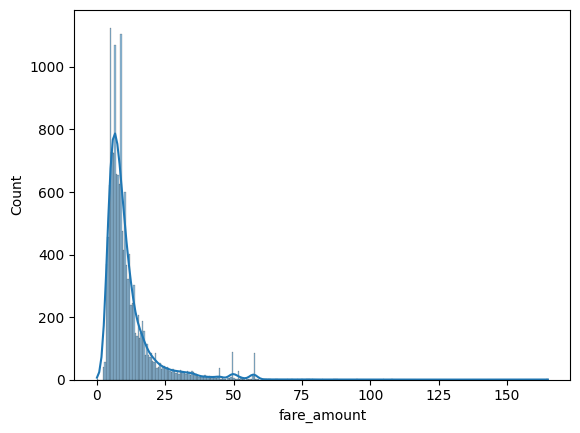

In [ ]:
sns.histplot(data=df_ap, x='fare_amount', kde=True)

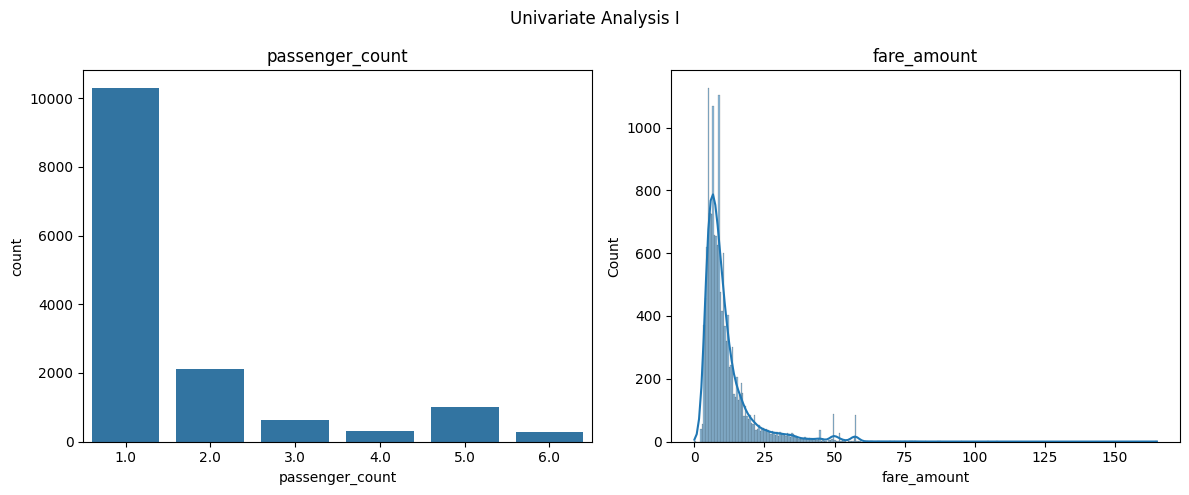

In [ ]:
# Univariate Analysis of distance
fig_I, axs_I = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plt.suptitle('Univariate Analysis I')

axs_I[0].set_title('passenger_count')
sns.countplot(data=df_ap, x='passenger_count', ax=axs_I[0])

axs_I[1].set_title('fare_amount')
sns.histplot(data=df_ap, x='fare_amount', kde=True, ax=axs_I[1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

##ii. Statistical Analysis
* Univariate Analysis
* Bivariate Analysis
* Multivariate Analysis

In [ ]:
df_ap.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'fare_amount'],
      dtype='object')

In [ ]:
# Numerical Bivariate Analysis of The Train Dataset
num_bivar_table1 = eda.numerical_bivariate_analysis(data=df_ap[['passenger_count', 'fare_amount']], target='fare_amount')
num_bivar_table1

No missing values found.
The target variable is fare_amount
Jarque-Bera test
The table has been created successfully in 0.034784 seconds


,feature,count,sum,min,mean,median,mode,max,std,var,p_val_norm,is_norm,corr_coef,corr_category,p_val_corr,is_corr,corr_test_method
0,passenger_count,14627.0,24333.00,1.00,1.663567,1.0,1.0,6.0,1.281713,1.642788,0.0,0,0.020284,Very Weak Correlation,0.014156,1,Spearman
1,fare_amount,14627.0,165105.11,0.01,11.287695,8.5,6.5,165.0,9.391318,88.196849,0.0,0,1.000000,Very Strong Correlation,0.000000,1,Spearman


#VII. DATA PREPROCESSING

##Type Conversion

In [ ]:
# Converting the data type of column pickup_datetime
df_ap['pickup_datetime_converted'] = pd.to_datetime(df_ap['pickup_datetime'])

##Feature Addition

In [ ]:
# Extracting new features from column pickup_datetime_converted
df_ap['year']      = df_ap['pickup_datetime_converted'].dt.year
df_ap['month']     = df_ap['pickup_datetime_converted'].dt.month
df_ap['hour']      = df_ap['pickup_datetime_converted'].dt.hour
df_ap['dayofweek'] = df_ap['pickup_datetime_converted'].dt.dayofweek

In [ ]:
# Adding new feature as column distance from columns pickup_latitude, pickup_longitude, dropoff_latitude, and dropoff_longitude
def calculate_distance(row):
    initial_point = (row['pickup_latitude'], row['pickup_longitude'])
    terminal_point = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(initial_point, terminal_point, ellipsoid='GRS-80').miles

df_ap['distance'] = df_ap.apply(calculate_distance, axis=1)

In [ ]:
# Checking for anomalies in column distance
df_ap['distance'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])
# df_ap[df_ap['distance'] == 0]

# GO BACK TO SECTION DATA CLEANSING AND HANDLE THIS PROBLEM!

count    14627.000000
mean         2.118371
std          2.647288
min          0.000087
10%          0.508958
20%          0.705623
30%          0.897649
40%          1.113581
50%          1.366671
60%          1.670388
70%          2.124264
80%          2.844043
90%          4.430131
max         80.391772
Name: distance, dtype: float64

In [ ]:
df_ap

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,pickup_datetime_converted,year,month,hour,dayofweek,day,distance
0,2013-02-20 07:14:00,-74.009683,40.713822,-73.981742,40.758860,1.0,12.0,2013-02-20 07:14:00,2013,2,7,2,20,3.436387
1,2015-05-02 22:26:34,-73.980568,40.729519,-73.973061,40.749512,1.0,8.5,2015-05-02 22:26:34,2015,5,22,5,2,1.434722
2,2014-04-18 18:54:00,-73.984037,40.729345,-73.965067,40.759427,1.0,9.0,2014-04-18 18:54:00,2014,4,18,4,18,2.302134
3,2012-05-27 08:28:32,-73.997025,40.736614,-73.992249,40.749332,1.0,4.5,2012-05-27 08:28:32,2012,5,8,6,27,0.912669
4,2011-10-25 16:06:51,-73.969675,40.762827,-73.971243,40.750877,1.0,6.1,2011-10-25 16:06:51,2011,10,16,1,25,0.828678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14622,2013-06-07 20:00:37,-73.994956,40.740023,-73.977783,40.725457,1.0,9.5,2013-06-07 20:00:37,2013,6,20,4,7,1.350089
14623,2013-05-31 10:23:45,-73.974472,40.732555,-74.015675,40.706280,1.0,15.5,2013-05-31 10:23:45,2013,5,10,4,31,2.822480
14624,2009-04-10 12:39:56,-73.976364,40.739887,-73.996498,40.719701,1.0,10.9,2009-04-10 12:39:56,2009,4,12,4,10,1.748460
14625,2012-03-28 16:17:00,-73.963768,40.765330,-73.961848,40.771137,5.0,3.7,2012-03-28 16:17:00,2012,3,16,2,28,0.413166


##Feature Transformation (unused)

In [ ]:
# Transforming A Dataset to make it more Gaussian Distribution
# df_ap = pd.concat([df_ap, pd.DataFrame(PowerTransformer().fit_transform(df_ap[[
#                                                                                'passenger_count', 'year',
#                                                                                'month',	'hour',	'dayofweek',
#                                                                                'day',	'distance']])).rename(columns={
#                                                                                                                       0: 'transformed_passenger_count',
#                                                                                                                       1: 'transformed_year',
#                                                                                                                       2: 'transformed_month',
#                                                                                                                       3: 'transformed_hour',
#                                                                                                                       4: 'transformed_dayofweek',
#                                                                                                                       5: 'transformed_day',
#                                                                                                                       6: 'transformed_distance'})], axis=1)

In [ ]:
# df_ap.drop(columns=['transformed_passenger_count', 'transformed_year', 'transformed_month', 'transformed_hour', 'transformed_dayofweek',
#                     'transformed_day', 'transformed_distance'], axis=1, inplace=True)

##Feature Polynomializing (unused)

In [ ]:
# feat_polynomializing = PolynomialFeatures(degree=4)
# feat_polynomializing.fit(df_ap[['passenger_count', 'year', 'month',	'hour',	'dayofweek', 'day',	'distance']])

# poly_result = feat_polynomializing.transform(df_ap[['passenger_count', 'year', 'month',	'hour',	'dayofweek', 'day',	'distance']])
# # poly_result_columns = feat_polynomializing.get_feature_names_out()

# # df_ap = pd.concat([pd.DataFrame(poly_result, columns=poly_result_columns), df_ap['fare_amount']], axis=1)
# poly_result = pd.DataFrame(poly_result)
# poly_result

,0,1,2,3,4,5,6,7,8,9,...,320,321,322,323,324,325,326,327,328,329
0,1.0,1.0,2013.0,2.0,7.0,2.0,20.0,3.436387,1.0,2013.0,...,47.235028,16000.0,2749.109770,472.350283,81.158924,160000.0,27491.097697,4723.502829,811.589236,139.446744
1,1.0,1.0,2015.0,5.0,22.0,5.0,2.0,1.434722,1.0,2015.0,...,51.460661,40.0,28.694435,20.584264,14.766346,16.0,11.477774,8.233706,5.906538,4.237119
2,1.0,1.0,2014.0,4.0,18.0,4.0,18.0,2.302134,1.0,2014.0,...,84.797110,23328.0,2983.565228,381.586997,48.803571,104976.0,13426.043527,1717.141488,219.616068,28.088086
3,1.0,1.0,2012.0,5.0,8.0,6.0,27.0,0.912669,1.0,2012.0,...,29.986745,118098.0,3992.015232,134.940351,4.561330,531441.0,17964.068543,607.231581,20.525985,0.693831
4,1.0,1.0,2011.0,10.0,16.0,1.0,25.0,0.828678,1.0,2011.0,...,0.686707,15625.0,517.923496,17.167664,0.569058,390625.0,12948.087401,429.191596,14.226458,0.471566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14622,1.0,1.0,2013.0,6.0,20.0,4.0,7.0,1.350089,1.0,2013.0,...,29.163857,1372.0,264.617500,51.036750,9.843453,2401.0,463.080626,89.314313,17.226042,3.322385
14623,1.0,1.0,2013.0,5.0,10.0,4.0,31.0,2.822480,1.0,2013.0,...,127.462320,119164.0,10849.614249,987.832981,89.939972,923521.0,84084.510429,7655.705603,697.034781,63.463449
14624,1.0,1.0,2009.0,4.0,12.0,4.0,10.0,1.748460,1.0,2009.0,...,48.913780,4000.0,699.383869,122.284449,21.380943,10000.0,1748.459673,305.711123,53.452357,9.345929
14625,1.0,5.0,2012.0,3.0,16.0,2.0,28.0,0.413166,25.0,10060.0,...,0.682825,43904.0,647.844644,9.559555,0.141060,614656.0,9069.825023,133.833764,1.974843,0.029141


In [ ]:
# df_ap.columns.tolist()
# df_ap['1'].describe()
# df_ap.drop(columns='1', axis=1, inplace=True)
# df_ap

,passenger_count,year,month,hour,dayofweek,day,distance,passenger_count^2,passenger_count year,passenger_count month,...,dayofweek day^3,dayofweek day^2 distance,dayofweek day distance^2,dayofweek distance^3,day^4,day^3 distance,day^2 distance^2,day distance^3,distance^4,fare_amount
0,1.0,2013.0,2.0,7.0,2.0,20.0,3.436387,1.0,2013.0,2.0,...,16000.0,2749.109770,472.350283,81.158924,160000.0,27491.097697,4723.502829,811.589236,139.446744,12.0
1,1.0,2015.0,5.0,22.0,5.0,2.0,1.434722,1.0,2015.0,5.0,...,40.0,28.694435,20.584264,14.766346,16.0,11.477774,8.233706,5.906538,4.237119,8.5
2,1.0,2014.0,4.0,18.0,4.0,18.0,2.302134,1.0,2014.0,4.0,...,23328.0,2983.565228,381.586997,48.803571,104976.0,13426.043527,1717.141488,219.616068,28.088086,9.0
3,1.0,2012.0,5.0,8.0,6.0,27.0,0.912669,1.0,2012.0,5.0,...,118098.0,3992.015232,134.940351,4.561330,531441.0,17964.068543,607.231581,20.525985,0.693831,4.5
4,1.0,2011.0,10.0,16.0,1.0,25.0,0.828678,1.0,2011.0,10.0,...,15625.0,517.923496,17.167664,0.569058,390625.0,12948.087401,429.191596,14.226458,0.471566,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14622,1.0,2013.0,6.0,20.0,4.0,7.0,1.350089,1.0,2013.0,6.0,...,1372.0,264.617500,51.036750,9.843453,2401.0,463.080626,89.314313,17.226042,3.322385,9.5
14623,1.0,2013.0,5.0,10.0,4.0,31.0,2.822480,1.0,2013.0,5.0,...,119164.0,10849.614249,987.832981,89.939972,923521.0,84084.510429,7655.705603,697.034781,63.463449,15.5
14624,1.0,2009.0,4.0,12.0,4.0,10.0,1.748460,1.0,2009.0,4.0,...,4000.0,699.383869,122.284449,21.380943,10000.0,1748.459673,305.711123,53.452357,9.345929,10.9
14625,5.0,2012.0,3.0,16.0,2.0,28.0,0.413166,25.0,10060.0,15.0,...,43904.0,647.844644,9.559555,0.141060,614656.0,9069.825023,133.833764,1.974843,0.029141,3.7


In [ ]:
# df_ap_copy = df_ap.copy()
# df_ap = pd.concat([df_ap,df_ap_copy['fare_amount']], axis=1)

##Dimensionality Reduction (Unused)

In [ ]:
# pca = PCA(n_components=221)
# pca.fit(df_ap.drop(columns='fare_amount', axis=1))
# df_ap = pca.transform(df_ap.drop(columns='fare_amount', axis=1))
# df_ap = pd.DataFrame(df_ap)
# df_ap = pd.concat([df_ap, df_ap_copy['fare_amount']], axis=1)

##Exploratory Data Analysis
(After Performing Data Preprocessing)

In [ ]:
# Numerical Bivariate Analysis II (After data preprocessing)
num_bivar_table2 = eda.numerical_bivariate_analysis(data=df_ap, exclude=['pickup_datetime', 'pickup_datetime_converted', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], target='fare_amount')
num_bivar_table2[num_bivar_table2['is_corr'] == 1].sort_values(by='p_val_corr')

,feature,count,sum,min,mean,median,mode,max,std,var,p_val_norm,is_norm,corr_coef,corr_category,p_val_corr,is_corr,corr_test_method
221,fare_amount,14627.0,165105.110000,1.000000e-02,1.128769e+01,8.500000e+00,6.500000e+00,1.650000e+02,9.391318e+00,8.819685e+01,0.000000e+00,0,1.000000,Very Strong Correlation,0.000000,1,Spearman
33,33,14627.0,0.000005,-3.113764e+07,3.322377e-10,2.735374e+04,-3.113764e+07,3.946681e+07,6.165763e+05,3.801663e+11,0.000000e+00,0,0.329210,Weak Correlation,0.000000,1,Spearman
30,30,14627.0,0.000005,-3.344152e+07,3.290542e-10,5.443561e+04,-3.344152e+07,5.651921e+07,9.688735e+05,9.387158e+11,0.000000e+00,0,0.370427,Weak Correlation,0.000000,1,Spearman
25,25,14627.0,-0.000125,-6.412526e+07,-8.557445e-09,7.887317e+05,-6.412526e+07,2.166415e+08,1.156161e+07,1.336708e+14,0.000000e+00,0,-0.333889,Weak Correlation,0.000000,1,Spearman
8,8,14627.0,-0.007278,-5.981852e+08,-4.976032e-07,3.498549e+07,-5.981852e+08,1.778766e+10,2.751376e+08,7.570068e+16,0.000000e+00,0,-0.766017,Strong Correlation,0.000000,1,Spearman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,119,14627.0,0.000012,-7.821324e+03,7.990844e-10,7.101047e+00,-7.821324e+03,1.011479e+04,5.107756e+02,2.608917e+05,0.000000e+00,0,0.017700,Very Weak Correlation,0.032303,1,Spearman
208,208,14627.0,-0.000002,-2.335034e+02,-1.054133e-10,-2.529822e-01,-2.335034e+02,2.668415e+02,1.908481e+01,3.642299e+02,0.000000e+00,0,-0.017617,Very Weak Correlation,0.033125,1,Spearman
20,20,14627.0,-0.000195,-2.480954e+08,-1.335776e-08,-4.652227e+05,-2.480954e+08,3.228516e+08,3.379747e+07,1.142269e+15,0.000000e+00,0,0.017584,Very Weak Correlation,0.033454,1,Spearman
18,18,14627.0,-0.000587,-5.525412e+07,-4.016294e-08,-5.052856e+06,-5.525412e+07,9.388236e+07,4.248422e+07,1.804909e+15,2.411780e-310,0,0.017318,Very Weak Correlation,0.036224,1,Spearman


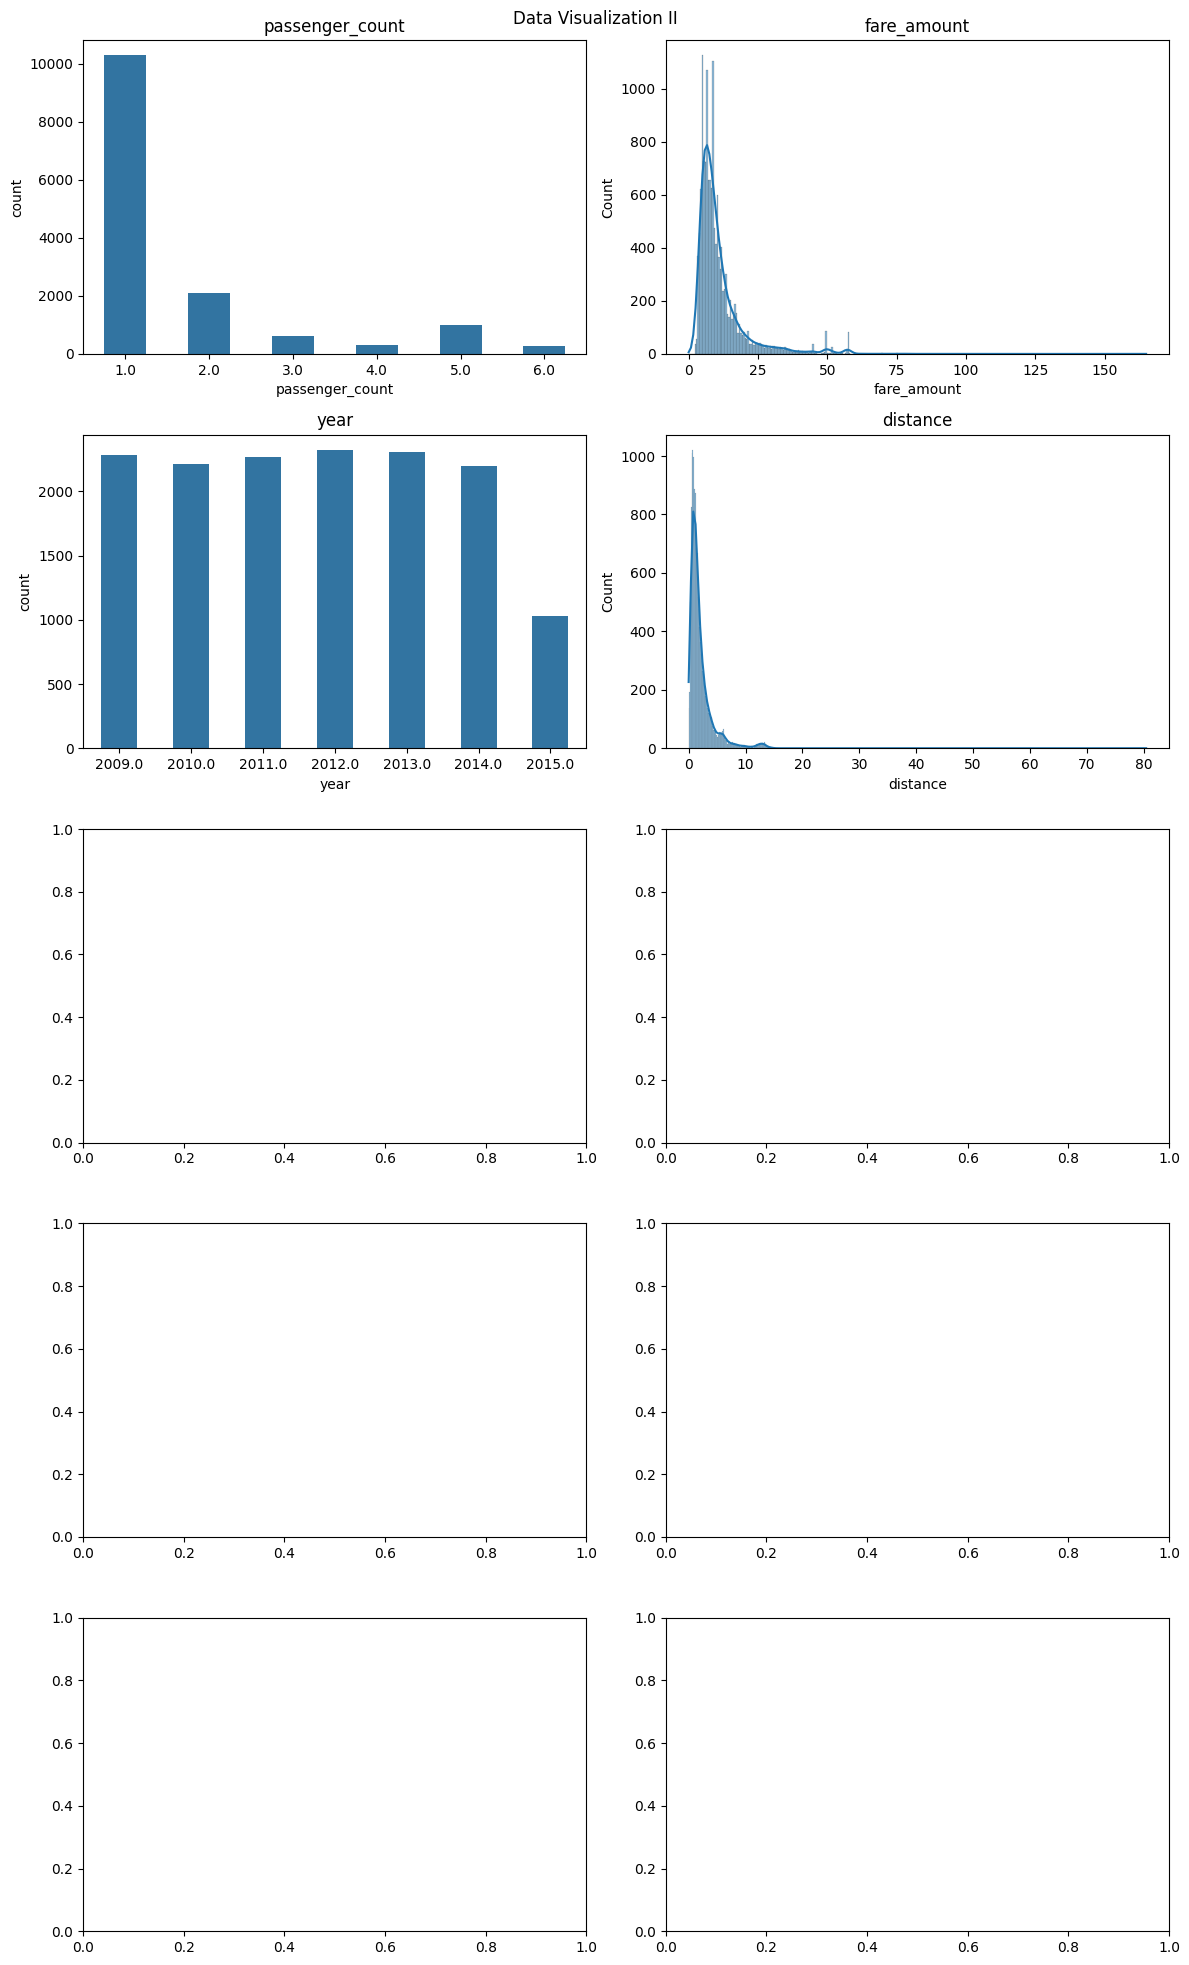

In [ ]:
# Data Visualization II
fig, axes = plt.subplots(5, 2, figsize=(12, 20))

plt.suptitle('Data Visualization II')

axes[0, 0].set_title('passenger_count')
sns.countplot(data=df_ap, x='passenger_count', ax=axes[0, 0], width=0.5)

axes[0, 1].set_title('fare_amount')
sns.histplot(data=df_ap, x='fare_amount', kde=True, ax=axes[0, 1])

axes[1, 0].set_title('year')
sns.countplot(data=df_ap, x='year', ax=axes[1, 0], width=0.5)

axes[1, 1].set_title('distance')
sns.histplot(data=df_ap, x='distance', kde=True, ax=axes[1, 1])

# axes[2,0].set_title('transformed_passenger_count')
# sns.histplot(data=df_ap, x='transformed_passenger_count', kde=True, ax=axes[2,0])

# axes[2,1].set_title('transformed_distance')
# sns.histplot(data=df_ap, x='transformed_distance', kde=True, ax=axes[2,1])

# axes[3,0].set_title('transformed_year')
# sns.countplot(data=df_ap, x='transformed_year', ax=axes[3,0], width=0.5)

# axes[3,1].set_title('transformed_month')
# sns.countplot(data=df_ap, x='transformed_month', ax=axes[3,1], width=0.5)

# axes[4, 0].set_title('year and fare_amount')
# sns.scatterplot(data=df_ap, x='year', y='fare_amount', ax=axes[4, 0])

# axes[4, 1].set_title('distance and fare_amount')
# sns.scatterplot(data=df_ap, x='distance', y='fare_amount', ax=axes[4, 1], hue='year')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Correlation matrix
# plt.figure(figsize=(10,4))
# sns.heatmap(df_ap.corr(method='spearman',numeric_only=True),annot=True, cbar=True, mask=np.triu(np.ones_like(df_ap.corr(method='spearman',numeric_only=True),dtype=bool)))

##Redefining Training and Testing Data

In [ ]:
# X_train and y_train
X_train = pd.concat([X_train, y_train], axis=1)
X_train.reset_index(drop=True, inplace=True)
y_train = X_train['fare_amount']
X_train.drop(columns='fare_amount', axis=1, inplace=True)

In [ ]:
# X_test and y_test
X_test = pd.concat([X_test, y_test], axis=1)
X_test.reset_index(drop=True, inplace=True)
y_test = X_test['fare_amount']
X_test.drop(columns='fare_amount', axis=1, inplace=True)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14627 entries, 0 to 14626
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_datetime    14627 non-null  object 
 1   pickup_longitude   14627 non-null  float64
 2   pickup_latitude    14627 non-null  float64
 3   dropoff_longitude  14627 non-null  float64
 4   dropoff_latitude   14627 non-null  float64
 5   passenger_count    14627 non-null  float64
dtypes: float64(5), object(1)
memory usage: 685.8+ KB


#VIII. MODEL BUILDING

##i. Class Transformers

In [ ]:
# Data Duplicate Transformer
class DataDuplicator(BaseEstimator, TransformerMixin):
      def fit(self, X, y=None):
          return self

      def transform(self, X, y=None):
          X_duplicated = X.copy()
          return X_duplicated

In [ ]:
# Numerical Missing Values Imputation Transformer
class NumericalFeatureImputer(BaseEstimator, TransformerMixin):
      def __init__(self, exclude=None, include=None):
          self.exclude = exclude
          self.include = include

      def fit(self, X, y=None):
          return self

      def transform(self, X, y=None):
          num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

          if self.exclude:
              num_cols = [col for col in num_cols if col not in self.exclude]
          if self.include:
              num_cols = [col for col in num_cols if col in self.include]

          if X[num_cols].isnull().any().any():
              imputer = SimpleImputer(strategy='median', copy=False)
              X[num_cols] = imputer.fit_transform(X[num_cols])

          return X

In [ ]:
# Categorical Missing Values Imputation Transformer
class CategoricalFeatureImputer(BaseEstimator, TransformerMixin):
      def __init__(self, exclude=None, include=None):
          self.exclude = exclude
          self.include = include

      def fit(self, X, y=None):
          return self

      def transform(self, X, y=None):
          cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

          if self.exclude:
              cat_cols = [col for col in cat_cols if col not in self.exclude]
          if self.include:
              cat_cols = [col for col in cat_cols if col in self.include]

          if X[cat_cols].isnull().any().any():
              imputer = SimpleImputer(strategy='most_frequent', copy=False)
              X[cat_cols] = imputer.fit_transform(X[cat_cols])

          return X

In [ ]:
# Feature Extraction Transformer
class FeatureExtractor(BaseEstimator, TransformerMixin):
      def fit(self, X, y=None):
          return self

      def transform(self, X, y=None):
          pickup_datetime = pd.to_datetime(X['pickup_datetime'])
          X['year']       = pickup_datetime.dt.year
          X['month']      = pickup_datetime.dt.month
          X['hour']       = pickup_datetime.dt.hour
          X['dayofweek']  = pickup_datetime.dt.dayofweek

          return X.drop(columns='pickup_datetime', axis=1)

In [ ]:
# Feature Addition Transformer
class FeatureAdder(BaseEstimator, TransformerMixin):
      def fit(self, X, y=None):
          return self

      def transform(self, X, y=None):
          def calculate_distance(row):
              initial_point = (row['pickup_latitude'], row['pickup_longitude'])
              terminal_point = (row['dropoff_latitude'], row['dropoff_longitude'])
              return geodesic(initial_point, terminal_point, ellipsoid='GRS-80').miles

          X['distance'] = X.apply(calculate_distance, axis=1)
          return X.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)

In [ ]:
# Transformers Pipeline for Data Preprocessing
preprocessors = Pipeline([
                          ('duplicator', DataDuplicator()),
                          ('imputer', NumericalFeatureImputer()),
                          ('imputer_cat', CategoricalFeatureImputer()),
                          ('extractor', FeatureExtractor()),
                          ('adder', FeatureAdder())
                          # ('polynomial', PolynomialFeatures(degree=4)),
                          # ('scaler', MinMaxScaler(feature_range=(0,100))),
                          # ('pca', PCA(n_components=200))
                          ])

##ii. Hyperparameter Tuning

In [ ]:
# ---------------------- Function For A Pipeline Model -------------------------
# - Algorithm: Linear Regression, Lasso, Ridge, LGBM, CatBoost
def create_pipeline(params):
    return Pipeline([
                     ('transformers', preprocessors),
                    #  ('estimator', CatBoostRegressor(
                    #                                    iterations          = params['iterations'],
                    #                                    learning_rate       = params['learning_rate'],
                    #                                    depth               = params['depth'],
                    #                                    l2_leaf_reg         = params['l2_leaf_reg'],
                    #                                    silent= True
                    #                                   #  min_data_in_leaf    = params['min_data_in_leaf'],
                    #                                   #  border_count        = params['border_count']))

                     ('estimator', LGBMRegressor(
                                                  n_estimators        = params['n_estimators'],
                                                  max_depth           = params['max_depth'],
                                                  learning_rate       = params['learning_rate'],
                                                  min_child_samples   = params['min_child_samples'],
                                                  num_leaves          = params['num_leaves'],
                                                  min_child_weight    = params['min_child_weight'],
                                                  reg_alpha           = params['reg_alpha'],
                                                  reg_lambda          = params['reg_lambda'],
                                                  importance_type     = 'split',
                                                  force_col_wise      = True
                                                  ))

                    #  ('estimator', Ridge(
                    #                      alpha         = params['alpha'],
                    #                      fit_intercept = params['fit_intercept'],
                    #                      max_iter      = params['max_iter'],
                    #                      tol           = params['tol'],
                    #                      solver        = params['solver']))

                    #  ('estimator', Lasso(alpha         = params['alpha'],
                    #                      fit_intercept = params['fit_intercept'],
                    #                      max_iter      = params['max_iter'],
                    #                      tol           = params['tol']))

                    #  ('estimator', LinearRegression(fit_intercept = params['fit_intercept'],
                    #                                 copy_X        = params['copy_X'],
                    #                                 n_jobs        = params['n_jobs']))
                      ])


In [ ]:
# --------------------- Defining The Objective Function ------------------------
def objective(trial):

    # Defining Values For The Parameters ---------------------------------------
    # Algorithm: CatBoostRegressor
    # params =  {'iterations'          : trial.suggest_int('iterations', 100, 150),
    #            'learning_rate'       : trial.suggest_float('learning_rate', 1e-2, 3e-1),
    #            'depth'               : trial.suggest_int('depth', 5, 16),
    #            'l2_leaf_reg'         : trial.suggest_float('l2_leaf_reg', 1, 1e1)
    #           #  'min_data_in_leaf'    : trial.suggest_int('min_data_in_leaf', 5, 120),
    #           #  'border_count'        : trial.suggest_int('border_count', 30, 150)
    #            }

    # -Algorithm: LGBMRegressor
    params = {'n_estimators'        : trial.suggest_int('n_estimators', 500, 1500),
              'max_depth'           : trial.suggest_int('max_depth', 5, 200),
              'learning_rate'       : trial.suggest_float('learning_rate', 1e-2, 3e-1),
              'min_child_samples'   : trial.suggest_int('min_child_samples', 5, 200),
              'num_leaves'          : trial.suggest_int('num_leaves', 20, 200),
              'min_child_weight'    : trial.suggest_float('min_child_weight', 1e-3, 1e2),
              'reg_alpha'           : trial.suggest_float('reg_alpha', 0, 1),
              'reg_lambda'          : trial.suggest_float('reg_lambda', 0, 1)
              # 'importance_type'     : trial.suggest_categorical('importance_type', ['gain'])
              }


    # - Algorithm: Ridge
    # params = {'alpha'         : trial.suggest_categorical('alpha', [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2,1e3, 1e4]),
    #           'fit_intercept' : trial.suggest_categorical('fit_intercept', [True, False]),
    #           'max_iter'      : trial.suggest_int('max_iter', 500, 2000),
    #           'tol'           : trial.suggest_categorical('tol', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]),
    #           'solver'        : trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    #           }

    # - Algorithm: Lasso
    # params = {'alpha'         : trial.suggest_float('alpha', 1e-5  , 1e4, step=None, log=True),
    #           'fit_intercept' : trial.suggest_categorical('fit_intercept', [True, False]),
    #           'max_iter'      : trial.suggest_int('max_iter', 500, 2000),
    #           'tol'           : trial.suggest_float('tol', 1e-5, 1e-1, step=None, log=True)
    #           }

    # - Algorithm: Linear Regression
    # params = {
    #           'fit_intercept' : trial.suggest_categorical('fit_intercept', [True, False]),
    #           'copy_X'        : trial.suggest_categorical('copy_X', [True, False]),
    #           'n_jobs'        : trial.suggest_categorical('n_jobs', [-1,1,2,3,4,5,6,7,8])
    #           }

    # Creating A Pipeline Model
    pipeline_model = create_pipeline(params)

    # Fitting The Pipeline Model For Hyperparameter Tuning
    pipeline_model.fit(X_train, y_train)

    # Predicting with The Pipeline Model For Hyperparameter Tuning
    y_predicted_HT = pipeline_model.predict(X_test)

    # Emphasize One of The Evaluation Metrics Below:
    score_result = r2_score(y_true= y_test, y_pred= y_predicted_HT)                            # R^2
    # score_result = mean_absolute_error(y_true= y_test, y_pred= y_predicted_HT)                 # MAE
    # score_result = mean_absolute_percentage_error(y_true= y_test, y_pred= y_predicted_HT)      # MAPE
    # score_result = mean_squared_error(y_true= y_test, y_pred= y_predicted_HT)                  # MSE
    # score_result = mean_squared_error(y_true= y_test, y_pred= y_predicted_HT, squared= False)  #RMSE

    return score_result

In [ ]:
# ---------------- Study or Tuning Process -------------------------------------
start_time = time.time()

# Setting The Study Parameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
elapsed_time = time.time() - start_time
elapsed_time = elapsed_time/60
# Finding The Best Parameters For The Algorithm
best_params = study.best_params

print(f"Study Process Done Successfully In {elapsed_time:.6f} minutes")
print("Best Parameters: ", best_params)
print("Best Score: ", study.best_value)

# Building and Traing A Temporary Model (Hyperparameter Tuning Model)
model_HT = create_pipeline(best_params)
model_HT.fit(X_train, y_train)

<ipython-input-61-2713b2ae5d1a>:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig_opt_hist = optuna.visualization.matplotlib.plot_optimization_history(study, error_bar=True)


<Figure size 640x480 with 0 Axes>

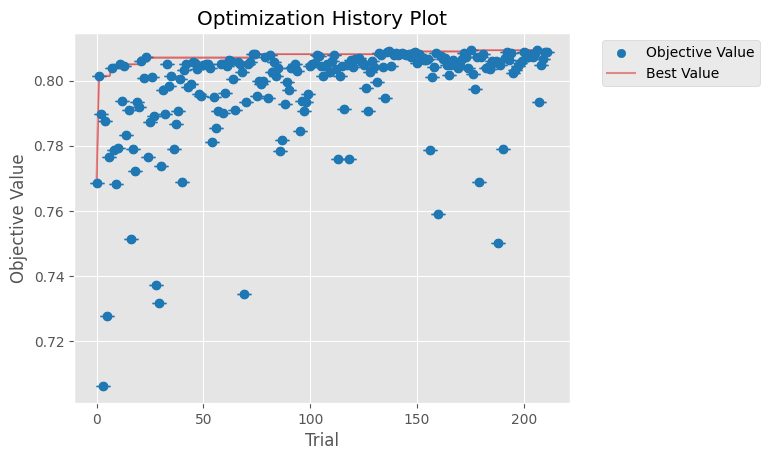

In [ ]:
# # Visualizing The Optimization History
# plt.figure()
# fig_opt_hist = optuna.visualization.matplotlib.plot_optimization_history(study, error_bar=True)
# # plt.savefig('/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_optimization_history_trial4.png')

In [ ]:
# best_params = {'n_estimators': 905, 'max_depth': 6, 'learning_rate': 0.020061741590177765, 'min_child_samples': 138, 'num_leaves': 169, 'min_child_weight': 53.125201632995314, 'reg_alpha': 0.820097598324331, 'reg_lambda': 0.9632122490987607}

In [ ]:
def save_best_params(trial, best_params, param_table_path):
    param_table = pd.read_csv(param_table_path)

    param_table_1 = pd.DataFrame(best_params, index=[0])
    num_trial = pd.DataFrame({'trial': trial}, index=[0])
    param_table_2 = pd.concat([num_trial, param_table_1], axis=1)
    param_table = pd.concat([param_table, param_table_2], axis=0, ignore_index=True)
    param_table.reset_index(drop=True, inplace=True)
    param_table.drop(columns='Unnamed: 0', errors='ignore', inplace=True, axis=1)

    param_table.to_csv(param_table_path)
    return param_table

In [ ]:
# param_table = save_best_params(trial=8, best_params=best_params, param_table_path='/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_param_table.csv')

In [ ]:
param_table

,trial,n_estimators,max_depth,learning_rate,min_child_samples,num_leaves,min_child_weight,reg_alpha,reg_lambda,importance_type,iterations,depth,l2_leaf_reg
0,6.0,549.0,14.0,0.010049,50.0,26.0,35.266652,0.043643,0.870173,split,NaN,NaN,NaN
1,7.0,NaN,NaN,0.091647,NaN,NaN,NaN,NaN,NaN,NaN,131.0,5.0,4.662554
2,8.0,905.0,6.0,0.020062,138.0,169.0,53.125202,0.820098,0.963212,NaN,NaN,NaN,NaN


In [ ]:
# --------------------------- Temporary Model ----------------------------------
# Setting Parameters
# algorithm_params = best_params
algorithm_params = {'n_estimators': 905, 'max_depth': 6, 'learning_rate': 0.020061741590177765, 'min_child_samples': 138, 'num_leaves': 169, 'min_child_weight': 53.125201632995314, 'reg_alpha': 0.820097598324331, 'reg_lambda': 0.9632122490987607}

# Fitting The Model
model_HT = create_pipeline(algorithm_params)
model_HT.fit(X_train, y_train)

# Predicting The Train Set with The Model
y_predicted_HT_train = model_HT.predict(X_train)

# Predicting The Test Set with The Model
y_predicted_HT_test = model_HT.predict(X_test)

# R2 Training Result
print("Best Training Score : ", r2_score(y_true= y_train, y_pred= y_predicted_HT_train))

# R2 Testing Result
print("Best Testing Score: ", r2_score(y_true= y_test, y_pred= y_predicted_HT_test))

##iii. Complete Model

In [ ]:
# -------------------- Complete Model ------------------------------------------
model = create_pipeline({'n_estimators': 549, 'max_depth': 14,
                         'learning_rate': 0.010048584905047987,
                         'min_child_samples': 50, 'num_leaves': 26,
                         'min_child_weight': 35.26665158007675,
                         'reg_alpha': 0.043642797546363,
                         'reg_lambda': 0.8701728080712965,
                         'importance_type': 'split'})

# Fitting The Model
model.fit(X_train, y_train)

#IX. EVALUATION

##Metrics

In [ ]:
# Function For Model Evaluation
def model_evaluation(model, trial, algo, best_params, preprocessing, num_var, X_train, X_test, y_train, y_test, eval_table_path):

    # Explain Here What Data-Preprocessing Methods You Have Done
    print(f"TRIAL-{trial} ----- Algorithm: {algo}")
    print(f"Preprocessing: {preprocessing}")
    print("Parameters:")
    best_params_str = str(best_params).replace("{", "").replace("}", "").replace("'", "")
    best_params_str = [best_params_str]
    print(best_params, "\n")

    # Fitting The Model
    model_ = model.fit(X_train, y_train)

    # Traing The Model
    y_predicted_trained = model_.predict(X_train)

    r2_train     = r2_score(y_true= y_train, y_pred= y_predicted_trained)
    adj_r2_train = 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-num_var-1)
    mae_train    = mean_absolute_error(y_true= y_train, y_pred= y_predicted_trained)
    mape_train   = mean_absolute_percentage_error(y_true= y_train, y_pred= y_predicted_trained)
    mse_train    = mean_squared_error(y_true= y_train, y_pred= y_predicted_trained)
    rmse_train   = mean_squared_error(y_true= y_train, y_pred= y_predicted_trained, squared= False)

    print("------ Training Result ------")
    print("Scores    :")
    print("   R^2    :", r2_train)
    print("   Adj R^2:", adj_r2_train)
    print("   MAE    :", mae_train)
    print("   MAPE   :", mape_train)
    print("   MSE    :", mse_train)
    print("   RMSE   :", rmse_train)
    print("   df     :", len(y_train)-num_var-1)

    # Testing The Model
    y_predicted_tested = model_.predict(X_test)

    r2_test     = r2_score(y_true= y_test, y_pred= y_predicted_tested)
    adj_r2_test = 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-num_var-1)
    mae_test    = mean_absolute_error(y_true= y_test, y_pred= y_predicted_tested)
    mape_test   = mean_absolute_percentage_error(y_true= y_test, y_pred= y_predicted_tested)
    mse_test    = mean_squared_error(y_true= y_test, y_pred= y_predicted_tested)
    rmse_test   = mean_squared_error(y_true= y_test, y_pred= y_predicted_tested, squared= False)

    print("\n------ Testing Result ------")
    print("Scores    :")
    print("   R^2    :", r2_test)
    print("   Adj R^2:", adj_r2_test)
    print("   MAE    :", mae_test)
    print("   MAPE   :", mape_test)
    print("   MSE    :", mse_test)
    print("   RMSE   :", rmse_test)

    appended_eval_table = pd.DataFrame({'trial': trial, 'algorithm': algo, 'params': best_params_str, 'preprocessing': preprocessing,
                                        'r2_train': r2_train, 'adj_r2_train': adj_r2_train, 'mae_train': mae_train, 'mape_train': mape_train, 'mse_train': mse_train, 'rmse_train': rmse_train,
                                        'r2_test': r2_test, 'adj_r2_test': adj_r2_test, 'mae_test': mae_test, 'mape_test': mape_test, 'mse_test': mse_test, 'rmse_test': rmse_test})
    eval_table = pd.read_csv(eval_table_path)
    eval_table = pd.concat([eval_table, appended_eval_table], axis=0, ignore_index=True)
    eval_table.reset_index(drop=True, inplace=True)
    eval_table.drop(columns='Unnamed: 0', errors='ignore', inplace=True, axis=1)
    eval_table.to_csv(eval_table_path)
    return eval_table

In [ ]:
evaluation_table = model_evaluation(model=model_HT, trial=8, algo='LGBM', best_params=best_params,
                                    preprocessing="Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance, PolynomialFeature: deg4",
                                    num_var=6, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                    eval_table_path='/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_evaluation_table.csv')

TRIAL-8 ----- Algorithm: LGBM
Preprocessing: Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance, PolynomialFeature: deg4
Parameters:
{'n_estimators': 905, 'max_depth': 6, 'learning_rate': 0.020061741590177765, 'min_child_samples': 138, 'num_leaves': 169, 'min_child_weight': 53.125201632995314, 'reg_alpha': 0.820097598324331, 'reg_lambda': 0.9632122490987607} 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37567
[LightGBM] [Info] Number of data points in the train set: 14627, number of used features: 209
[LightGBM] [Info] Start training from score 11.287695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [ ]:
evaluation_table = model_evaluation(model=model_HT, trial=7, algo='CatBosst', best_params=best_params,
                                    preprocessing="Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance, PolynomialFeature: deg4",
                                    num_var=6, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                    eval_table_path='/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_evaluation_table.csv')

TRIAL-7 ----- Algorithm: CatBosst
Preprocessing: Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance, PolynomialFeature: deg4
Parameters:
{'iterations': 131, 'learning_rate': 0.09164702368662664, 'depth': 5, 'l2_leaf_reg': 4.662554116692512} 

------ Training Result ------
Scores    :
   R^2    : 0.852835104454426
   Adj R^2: 0.852774708464462
   MAE    : 1.945439391408068
   MAPE   : 0.23680308761856492
   MSE    : 12.978592726091893
   RMSE   : 3.602581397566458
   df     : 14620

------ Testing Result ------
Scores    :
   R^2    : 0.8178151871060162
   Adj R^2: 0.8175157052218069
   MAE    : 2.0571561845985116
   MAPE   : 0.2033346215508035
   MSE    : 15.80015688653578
   RMSE   : 3.974941117367121


In [ ]:
evaluation_table = model_evaluation(model=model_HT, trial=6, algo='LGBM', best_params=best_params,
                                    preprocessing="Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance",
                                    num_var=6, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                    eval_table_path='/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_evaluation_table.csv')

TRIAL-6 ----- Algorithm: LGBM
Preprocessing: Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance
Parameters:
{'n_estimators': 549, 'max_depth': 14, 'learning_rate': 0.010048584905047987, 'min_child_samples': 50, 'num_leaves': 26, 'min_child_weight': 35.26665158007675, 'reg_alpha': 0.043642797546363, 'reg_lambda': 0.8701728080712965, 'importance_type': 'split'} 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 14627, number of used features: 6
[LightGBM] [Info] Start training from score 11.287695
------ Training Result ------
Scores    :
   R^2    : 0.8265625880315084
   Adj R^2: 0.8264914098870617
   MAE    : 1.9405491471934335
   MAPE   : 0.2581581262710755
   MSE    : 15.295587477309672
   R

In [ ]:
evaluation_table = model_evaluation(model=model_HT, trial=5, algo='Ridge', best_params=best_params,
                                    preprocessing="Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance, PolynomialFeat: deg4, MinMaxScaler: 0-100",
                                    num_var=210, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                    eval_table_path='/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_evaluation_table.csv')

TRIAL-5 ----- Algorithm: Ridge
Preprocessing: Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance, PolynomialFeat: deg4, MinMaxScaler: 0-100
Parameters:
{'alpha': 0.001, 'fit_intercept': False, 'max_iter': 604, 'tol': 0.1, 'solver': 'sag'} 

------ Training Result ------
Scores    :
   R^2    : 0.7537464725967201
   Adj R^2: 0.7501592611126269
   MAE    : 2.4231848348803173
   MAPE   : 0.2873933862316114
   MSE    : 21.71730036352952
   RMSE   : 4.660182438867552
   df     : 14416

------ Testing Result ------
Scores    :
   R^2    : 0.7480158483248789
   Adj R^2: 0.7326598785478111
   MAE    : 2.454809370385072
   MAPE   : 0.23696017744768824
   MSE    : 21.85357311701044
   RMSE   : 4.674780542122853


In [ ]:
evaluation_table = model_evaluation(model=model_HT, trial=4, algo='Ridge', best_params=best_params,
                                    preprocessing="Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance",
                                    num_var=6, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                    eval_table_path='/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_evaluation_table.csv')

TRIAL-4 ----- Algorithm: Ridge
Preprocessing: Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance
Parameters:
{'alpha': 6.126985168132168, 'fit_intercept': False, 'max_iter': 670, 'tol': 0.007307693114085385, 'solver': 'saga'} 

------ Training Result ------
Scores    :
   R^2    : 0.48203261551962673
   Adj R^2: 0.4818200434056129
   MAE    : 3.8581251759674347
   MAPE   : 0.46915625195514205
   MSE    : 45.67996806336192
   RMSE   : 6.758695736853518
   df     : 14620

------ Testing Result ------
Scores    :
   R^2    : 0.35096798273147634
   Adj R^2: 0.3499010807852815
   MAE    : 3.965103816384974
   MAPE   : 0.43446480734217563
   MSE    : 56.287939342094944
   RMSE   : 7.502528863129748


In [ ]:
evaluation_table = model_evaluation(model=model_HT, trial=3, algo='Lasso', best_params=best_params,
                                    preprocessing="Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance",
                                    num_var=6, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                    eval_table_path='/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_evaluation_table.csv')

TRIAL-3 ----- Algorithm: Lasso
Preprocessing: Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance
Parameters:
['alpha: 6.761049490687139, fit_intercept: False, max_iter: 973, tol: 0.0013489495393265427'] 

------ Training Result ------
Scores    :
   R^2    : 0.48097455651476306
   Adj R^2: 0.48076155017680744
   MAE    : 3.8673099367443657
   MAPE   : 0.471457154576229
   MSE    : 45.773279153981676
   RMSE   : 6.765595254963282
   df     : 14620

------ Testing Result ------
Scores    :
   R^2    : 0.3493073489357097
   Adj R^2: 0.34823771718053553
   MAE    : 3.970405165581897
   MAPE   : 0.43535671208417975
   MSE    : 56.4319594395301
   RMSE   : 7.512120834992612


In [ ]:
evaluation_table = model_evaluation(model=model_HT, trial=2, algo='Lasso', best_params=best_params,
                                    preprocessing="Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance",
                                    num_var=6, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                    eval_table_path='/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_evaluation_table.csv')

TRIAL-2 ----- Algorithm: Lasso
Preprocessing: Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance
Parameters:
['alpha: 4140.972818386517, fit_intercept: True, max_iter: 1350, tol: 0.04066377664150914'] 

------ Training Result ------
Scores    :
   R^2    : 0.5634505218831998
   Adj R^2: 0.5632713634106484
   MAE    : 2.9604208650059882
   MAPE   : 0.3606133807176047
   MSE    : 38.49965618676589
   RMSE   : 6.204809117673636
   df     : 14620

------ Testing Result ------
Scores    :
   R^2    : 0.2765290894160374
   Adj R^2: 0.27533982216576236
   MAE    : 3.0912543947663558
   MAPE   : 0.33773810576322594
   MSE    : 62.74372549770855
   RMSE   : 7.921093705903784


In [ ]:
evaluation_table = model_evaluation(model=model_HT, trial=1, algo='Linear Regression', best_params=best_params,
                                    preprocessing="Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance",
                                    num_var=6, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                    eval_table_path='/content/drive/MyDrive/DATA_SCIENCE/ML_S_Regression_Taxi_Fare_evaluation_table.csv')

TRIAL-1 ----- Algorithm: Linear Regression
Preprocessing: Type Conversion: pickup_datetime, Feature Addition: year,month,day,hour,distance
Parameters:
['fit_intercept: True, copy_X: True, n_jobs: -1'] 

------ Training Result ------
Scores    :
   R^2    : 0.5699389623239495
   Adj R^2: 0.5697624666860523
   MAE    : 2.818074291266633
   MAPE   : 0.3460265850469696
   MSE    : 37.92743530762344
   RMSE   : 6.158525416658069
   df     : 14620

------ Testing Result ------
Scores    :
   R^2    : 0.25058950531529733
   Adj R^2: 0.24935759765280185
   MAE    : 2.9651346648687618
   MAPE   : 0.32301604519939014
   MSE    : 64.9933614133086
   RMSE   : 8.061846030116714


In [ ]:
evaluation_table

,trial,algorithm,params,preprocessing,r2_train,adj_r2_train,mae_train,mape_train,mse_train,rmse_train,r2_test,adj_r2_test,mae_test,mape_test,mse_test,rmse_test
0,1,Linear Regression,"fit_intercept: True, copy_X: True, n_jobs: -1","Type Conversion: pickup_datetime, Feature Addi...",0.569939,0.569762,2.818074,0.346027,37.927435,6.158525,0.250590,0.249358,2.965135,0.323016,64.993361,8.061846
1,2,Lasso,"alpha: 4140.972818386517, fit_intercept: True,...","Type Conversion: pickup_datetime, Feature Addi...",0.563451,0.563271,2.960421,0.360613,38.499656,6.204809,0.276529,0.275340,3.091254,0.337738,62.743725,7.921094
2,3,Lasso,"alpha: 6.761049490687139, fit_intercept: False...","Type Conversion: pickup_datetime, Feature Addi...",0.480975,0.480762,3.867310,0.471457,45.773279,6.765595,0.349307,0.348238,3.970405,0.435357,56.431959,7.512121
3,4,Ridge,"alpha: 6.126985168132168, fit_intercept: False...","Type Conversion: pickup_datetime, Feature Addi...",0.482033,0.481820,3.858125,0.469156,45.679968,6.758696,0.350968,0.349901,3.965104,0.434465,56.287939,7.502529
4,5,Ridge,"alpha: 0.001, fit_intercept: False, max_iter: ...","Type Conversion: pickup_datetime, Feature Addi...",0.753746,0.750159,2.423185,0.287393,21.717300,4.660182,0.748016,0.732660,2.454809,0.236960,21.853573,4.674781
5,6,LGBM,"n_estimators: 549, max_depth: 14, learning_rat...","Type Conversion: pickup_datetime, Feature Addi...",0.826563,0.826491,1.940549,0.258158,15.295587,3.910957,0.809411,0.809097,2.050095,0.203548,16.529042,4.065592
6,7,CatBosst,"iterations: 131, learning_rate: 0.091647023686...","Type Conversion: pickup_datetime, Feature Addi...",0.852835,0.852775,1.945439,0.236803,12.978593,3.602581,0.817815,0.817516,2.057156,0.203335,15.800157,3.974941
7,8,LGBM,"n_estimators: 905, max_depth: 6, learning_rate...","Type Conversion: pickup_datetime, Feature Addi...",0.844153,0.844089,1.865319,0.229033,13.744282,3.707328,0.812910,0.812602,2.060778,0.200419,16.225581,4.028099


##Residual Plot

In [ ]:
# Function for Resudual Plots
def plot_residual(model, X_train, X_test, y_train, y_test, save_plot=False, plot_path=None):
    trial = input("Enter Trial Number: ")
    algo = input("Enter Algorithm: ")

    data1 = pd.concat([y_train, pd.DataFrame(model.predict(X_train))], axis=1).rename(columns={0:"Predicted Values"})
    data1["Residual"] = y_train - data1["Predicted Values"]
    data1["label"] = "Train"

    data2 = pd.concat([y_test, pd.DataFrame(model.predict(X_test))], axis=1).rename(columns={0:"Predicted Values"})
    data2["Residual"] = y_test - data2["Predicted Values"]
    data2["label"] = "Test"
    data = pd.concat([data1, data2], axis=0).reset_index(drop=True)

    plt.title(f"Residual Plot: Trial-{trial} with The {algo} Algorithm")
    sns.scatterplot(data=data, x="Predicted Values", y="Residual", hue="label")
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label="error = 0")
    if save_plot == True:
        plt.savefig(plot_path)
        plt.show()
    else:
        plt.show()

Enter Trial Number: 8
Enter Algorithm: LGBM


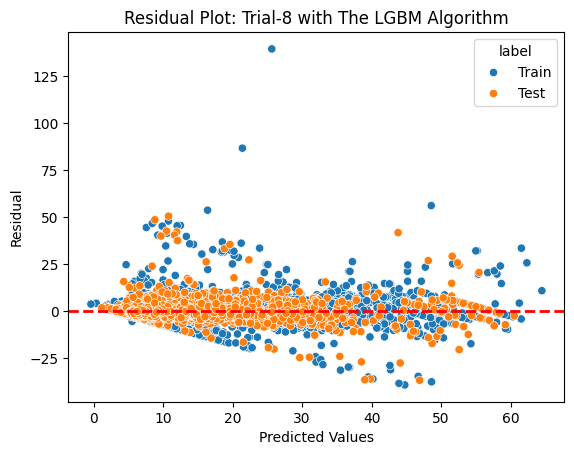

In [ ]:
plot_residual(model=model_HT, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, save_plot=False, plot_path=None)

Enter Trial Number: 6
Enter Algorithm: LGBM


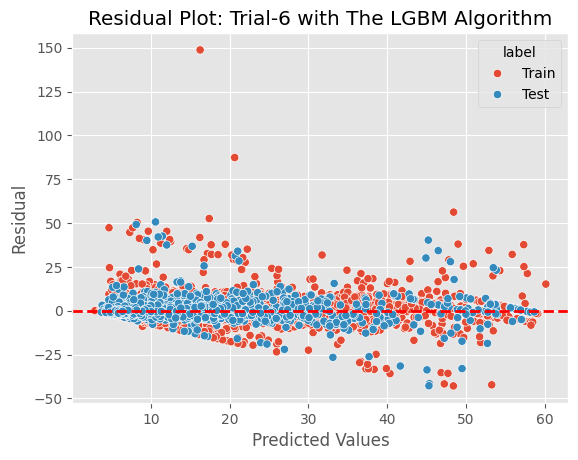

In [ ]:
plot_residual(model=model_HT, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, save_plot=False, plot_path=None)

Enter Trial Number: 5
Enter Algorithm: Ridge


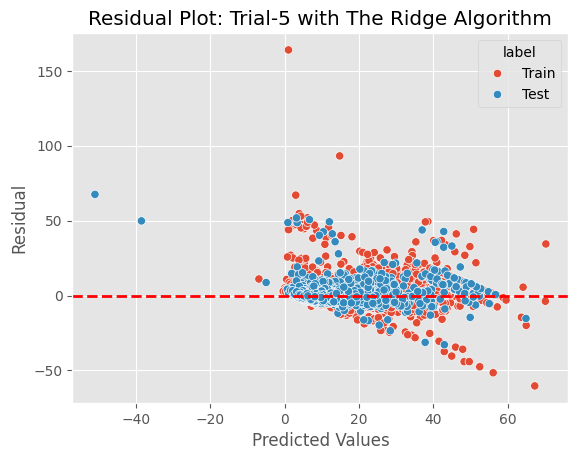

In [ ]:
plot_residual(model=model_HT, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, save_plot=False, plot_path=None)

Enter Trial Number: 4
Enter Algorithm: Ridge


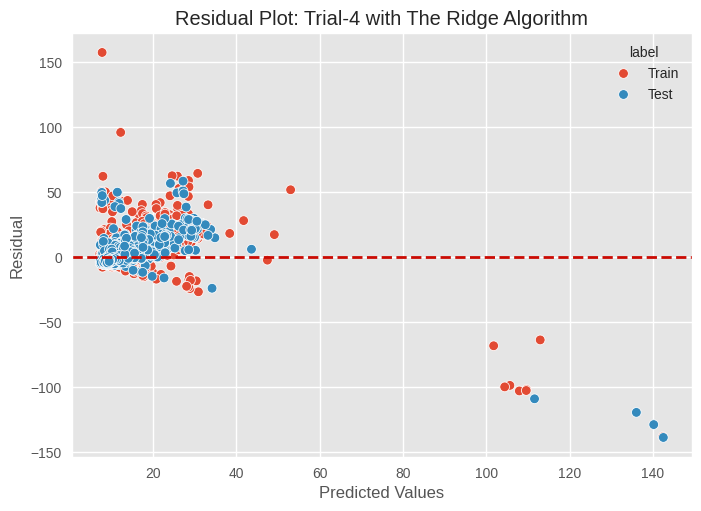

In [ ]:
plot_residual(model=model_HT, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, save_plot=False, plot_path=None)

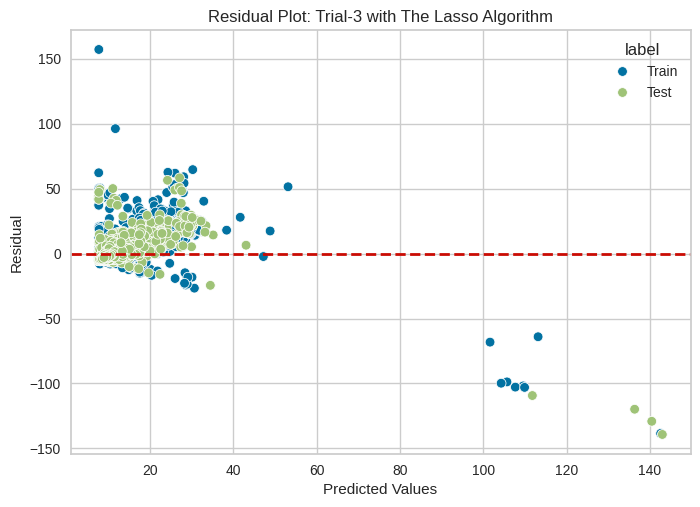

In [ ]:
plot_residual(model=model_HT, trial=3, algo='Lasso', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, save_plot=False, plot_path=None)

#X. CONCLUSION

trial 6 is chosen ------

Model Evaluation:
```
  ------ Training Result ------
  Scores    :
    R^2    : 0.8265625880315084
    Adj R^2: 0.8264914098870617
    MAE    : 1.9405491471934335
    MAPE   : 0.2581581262710755
    MSE    : 15.295587477309672
    RMSE   : 3.910957360712294
    df     : 14620

  ------ Testing Result ------
  Scores    :
    R^2    : 0.809410728434302
    Adj R^2: 0.8090974310015913
    MAE    : 2.0500952805744177
    MAPE   : 0.20354753056241046
    MSE    : 16.529041821839172
    RMSE   : 4.065592431840551
```

to predict the fare amount of a taxi ride that passengers have to pay, we use the LightGBM Regressor Algorithm with the parameters below:

* n_estimators: 549
* max_depth: 14
* learning_rate: 0.010048584905047987
* min_child_samples: 50
* num_leaves: 26
* min_child_weight: 35.26665158007675
* reg_alpha: 0.043642797546363
* reg_lambda: 0.8701728080712965
* importance_type: 'split'

Also, the data must be preprocessed initially by going through all the steps below:
1. Convert the data type of column pickup_datetime into datetime
2. Extract columns year, month, hour,and dayofweek
3. Drop column pickup_datetime
4. Adding or extract a new feature (distance) with geodesic from columns pickup_latitude, pickup_longitude, dropoff_latitude, and dropoff_longitude
5. Drop columns pickup_latitude, pickup_longitude, dropoff_latitude, and dropoff_longitude

Make sure that the dataset is already free from anomalies before going through all of the steps above!
